In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from astropy.table import Table
from desitarget.targetmask import desi_mask

%matplotlib inline

In [59]:
datapath = "/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/"
tiles = glob.glob(datapath+"*.fits")
print('Total numer of tiles:', len(tiles))

Total numer of tiles: 7098


In [60]:
int(tiles[0].split('_')[-1].split('.')[0])

13200

In [95]:
tilefile = tiles[100]
fx = fits.open(tilefile)
print(fx.info())
print('\nFIBERASSIGN columns:')
print(fx['FIBERASSIGN'].data.dtype.names)
print('\nPOTENTIAL columns:')
print(fx['POTENTIAL'].data.dtype.names)
print('\nGFA columns:')
print(fx['GFA'].data.dtype.names)
#fx.close()

Filename: /global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_17230.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  FIBERASSIGN    1 BinTableHDU    225   5000R x 108C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J, E, E, E, 3A, I, J, J, J, J, 4A, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, E, E, E, E, E, E, E, L, E, E, E, E, E, E, L, 1A, D, K, J, J]   
  2  POTENTIAL     1 BinTableHDU     15   50126R x 3C   [K, J, J]   
  3  SKYETC        1 BinTableHDU     37   20R x 14C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J]   
  4  TARGETS       1 BinTableHDU    201   5000R x 96C   [K, J, J, 8A, J, 4A, D, D, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E

In [104]:
a = fx[0]
fx.info()

Filename: /global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_17230.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  FIBERASSIGN    1 BinTableHDU    225   5000R x 108C   ['J', 'J', 'I', 'J', 'K', 'K', 'K', 'K', 'D', 'D', 'E', 'E', '8A', 'J', 'E', 'E', 'E', '3A', 'I', 'J', 'J', 'J', 'J', '4A', 'E', 'E', '5E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'I', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'I', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'K', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'L', 'E', 'E', 'E', 'E', 'E', 'E', 'L', '1A', 'D', 'K', 'J', 'J']   
  2  POTENTIAL     1 BinTableHDU     15   50126R x 3C   ['K', 'J', 'J']   
  3  SKYETC        1 BinTableHDU     37   20R x 14C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J]   
  4  TARGETS    

In [62]:


assigned = Table.read(tilefile, 'FIBERASSIGN')
gfa = Table.read(tilefile, 'GFA')
skyetc = Table.read(tilefile, 'SKYETC')


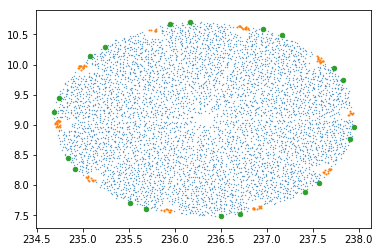

In [63]:
plt.scatter(assigned['TARGET_RA'], assigned['TARGET_DEC'], s=0.1)
plt.scatter(gfa['RA'], gfa['DEC'], s=1.0)
plt.scatter(skyetc['RA'], skyetc['DEC'], s=20.0)

In [107]:
def count_targets(tilefile):
    
    tileid = int(tilefile.split('_')[-1].split('.')[0])
    
    # mask for sky targets
    sky_mask = desi_mask.SKY
    
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # This is the field with the assignments
    assigned = Table.read(tilefile, 'FIBERASSIGN')
    
    # This is the field with the potential assigments
    potential = Table.read(tilefile, 'POTENTIAL')

    # Unassigned fibers have TARGETID==-1
    nassigned = len(assigned)-np.count_nonzero(assigned['TARGETID']==-1)
    
    # find whether a sky or stdstar target has been assigned
    nstd = np.count_nonzero(assigned['DESI_TARGET'] & std_mask)
    nsky = np.count_nonzero(assigned['DESI_TARGET'] & sky_mask)
    npotential = len(potential)

    # the number of science targets assigned
    nscience = nassigned - nstd - nsky
    
    
    return {'tileid':tileid,
            'RA':np.median(assigned['TARGET_RA']),
            'DEC':np.median(assigned['TARGET_DEC']),
            'npotential':npotential, 'nscience':nscience, 'nstd':nstd, 'nsky':nsky}

In [129]:
n_tiles = len(tiles)
#n_tiles = 2000
count_all = {}
for i in range(n_tiles):
    count_all[i] = count_targets(tiles[i])
    if not(i % (n_tiles//100)):
        print("{:}%  ".format(int(100.0*i/n_tiles)), end="\b")

0% 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 

In [130]:
all_sky = np.ones(n_tiles)
all_std = np.ones(n_tiles)
all_avail = np.ones(n_tiles)
all_science = np.ones(n_tiles)
all_ra = np.ones(n_tiles)
all_dec = np.ones(n_tiles)
all_tileid = np.ones(n_tiles, dtype=int)
for i in range(n_tiles):
    all_sky[i] = count_all[i]['nsky']
    all_std[i] = count_all[i]['nstd']
    all_avail[i] = count_all[i]['npotential']
    all_science[i] = count_all[i]['nscience']
    all_ra[i] = count_all[i]['RA']
    all_dec[i] = count_all[i]['DEC']
    all_tileid[i] = count_all[i]['tileid']

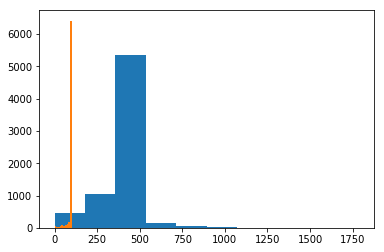

In [131]:
_ = plt.hist(all_sky)
_ = plt.hist(all_std)

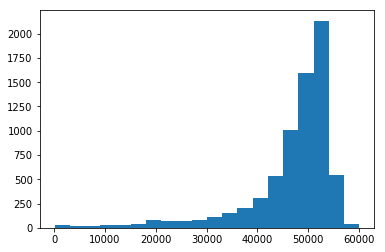

In [132]:
_ = plt.hist(all_avail, bins=20)

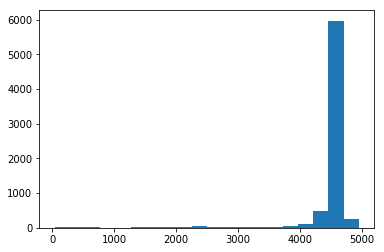

In [133]:
_ = plt.hist(all_science, bins=20)

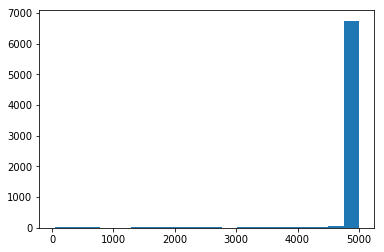

In [134]:
_ = plt.hist(all_science+all_sky+all_std, bins=20)

Text(0.5,1,'Number of Assigned Targets in a Tile')

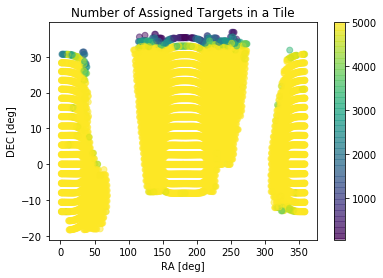

In [149]:
plt.scatter(all_ra, all_dec, c=all_science+all_sky+all_std, alpha=0.5)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.colorbar()
plt.title('Number of Assigned Targets in a Tile')

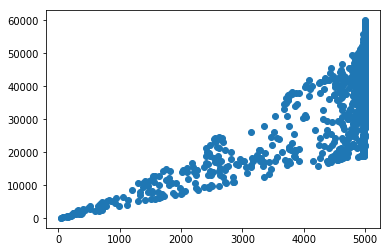

In [145]:
plt.scatter(all_science+all_sky+all_std, all_avail)

In [116]:
all_used = np.sort(all_science+all_sky+all_std)

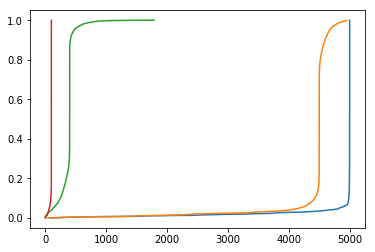

In [140]:
plt.plot(all_used, np.linspace(0,1,len(all_used)))
plt.plot(np.sort(all_science), np.linspace(0,1,len(all_science)))
plt.plot(np.sort(all_sky), np.linspace(0,1,len(all_sky)))
plt.plot(np.sort(all_std), np.linspace(0,1,len(all_std)))

In [143]:
np.percentile(all_science, q=[14,50,86])

array([ 4479.,  4500.,  4557.])

In [144]:
np.percentile(all_sky, q=[14,50,86])

array([ 295.,  400.,  402.])

In [146]:
np.percentile(all_std, q=[14,50,86])

array([  98.,  100.,  100.])